# Exploratory Data Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import seaborn as sns
import surprise
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)

### Dataset

- For this analysis the [MovieLens 100K Dataset](https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset) is utilized.

- Were collected by the GroupLens Research Project which is a research group in the Department of Computer Science and Engineering at the University of Minnesota

This data set consists of:

- 100,000 ratings (1-5) from 943 users on 1682 movies.
- Each user has rated at least 20 movies.

The data was collected during a seven-month period from September 19th, 1997 through April 22nd, 1998.

In [2]:
# data

cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    os.path.join("../data", "ml-100k", "u.data"),
    sep="\t",
    names=cols,
    encoding="latin-1",
)

ratings
ratings = ratings.drop(columns=["timestamp"])
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [3]:
# Movies data

cols = [
    "movie_id",
    "movie_title",
    "release_date",
    "video_release_date",
    "IMDb_URL",
    "unknown",
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

movies_data = pd.read_csv(
    os.path.join("../data", "ml-100k", "u.item"),
    sep="|",
    names=cols,
    encoding="latin-1",
)
movies_data.head()

movie_titles = movies_data[['movie_id', 'movie_title']]
movie_titles.head(3)

,movie_id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)


## Exploratory Data Analysis EDA

In [4]:
# Description of the data

user_key = "user_id"
item_key = "movie_id"

N = len(np.unique(ratings[user_key]))
M = len(np.unique(ratings[item_key]))
print("Number of users  : %d" % N)
print("Number of movies : %d" % M)

Number of users  : 943
Number of movies : 1682


In [5]:
print("Average number of ratings per user : %.0f" % (len(ratings) / N))
print("Average number of ratings per movie: %.0f" % (len(ratings) / M))

Average number of ratings per user : 106
Average number of ratings per movie: 59


In [6]:
movies_full = pd.merge(ratings, movie_titles, right_on='movie_id', left_on='movie_id')
movies_full.head()

,user_id,movie_id,rating,movie_title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [7]:
movies_agg = movies_full[['movie_title','rating']].groupby(by='movie_title').agg(['count','mean'])['rating'].reset_index()

# If at least 20 rankings

top_rankings = movies_agg[movies_agg['count'] >=20].sort_values('mean', ascending=False).iloc[:5]
top_rankings['mean'] = top_rankings['mean'].round(decimals = 2)
top_rankings

# Highest ranked movies by all users

,movie_title,count,mean
318,"Close Shave, A (1995)",112,4.49
1281,Schindler's List (1993),298,4.47
1652,"Wrong Trousers, The (1993)",118,4.47
273,Casablanca (1942),243,4.46
1597,Wallace & Gromit: The Best of Aardman Animatio...,67,4.45


In [8]:
movies_agg = movies_full[['movie_title','rating']].groupby(by='movie_title').agg(['count','mean'])['rating'].reset_index()

# If at least 20 rankings

# Most ranked movies

movies_agg[movies_agg['count'] >=20].sort_values('count', ascending=False).iloc[:5][['movie_title','count']]

,movie_title,count
1398,Star Wars (1977),583
333,Contact (1997),509
498,Fargo (1996),508
1234,Return of the Jedi (1983),507
860,Liar Liar (1997),485


In [9]:
low_rankings = movies_agg[movies_agg['count'] >=20].sort_values('mean', ascending=True).iloc[:5]
low_rankings['mean'] = low_rankings['mean'].round(decimals = 2)
low_rankings

,movie_title,count,mean
849,Lawnmower Man 2: Beyond Cyberspace (1996),21,1.71
560,Free Willy 3: The Rescue (1997),27,1.74
854,Leave It to Beaver (1997),44,1.84
176,Bio-Dome (1996),31,1.90
124,Barb Wire (1996),30,1.93


In [10]:
movies_agg[movies_agg['count'] >=20].sort_values('count', ascending=True).iloc[:5][['movie_title','count']]

,movie_title,count
955,Maximum Risk (1996),20
159,"Beverly Hillbillies, The (1993)",20
649,Half Baked (1998),20
1187,"Prophecy II, The (1998)",20
822,Kiss of Death (1995),20


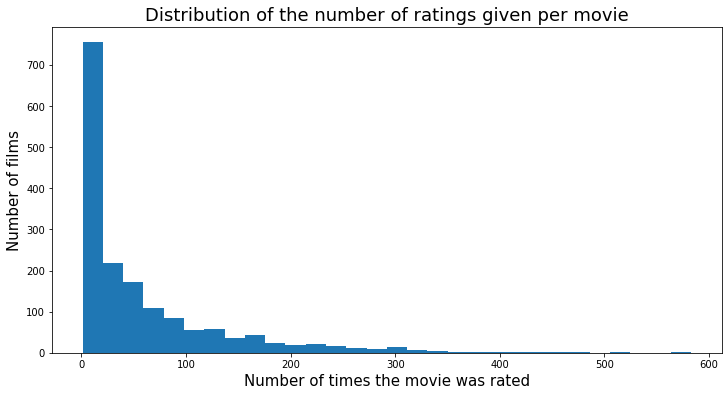

In [11]:
df_grp = movies_full[['movie_id','rating']].groupby(by='movie_id').agg(['count','mean'])['rating'].reset_index()

plt.figure(figsize=(12,6))
plt.hist(df_grp['count'], bins=30)
plt.title('Distribution of the number of ratings given per movie', fontsize=18)
plt.xlabel('Number of times the movie was rated', fontsize=15)
plt.ylabel('Number of films', fontsize=15)
#plt.savefig("hist_dist_count_ratings.png",dpi=400, bbox_inches='tight')
plt.show()

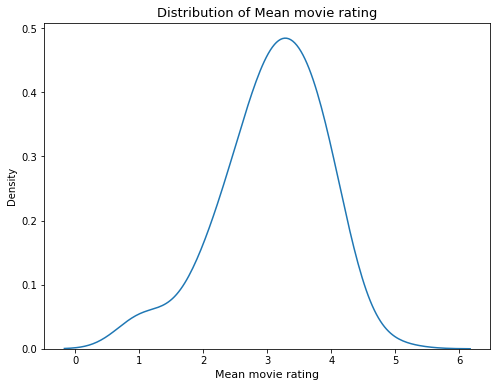

In [12]:
plt.figure(figsize=(8,6))
sns.kdeplot(data = df_grp, x = 'mean', bw_method=0.5)
plt.title('Distribution of Mean movie rating', fontsize=13)
plt.xlabel('Mean movie rating', fontsize=11)
plt.show();

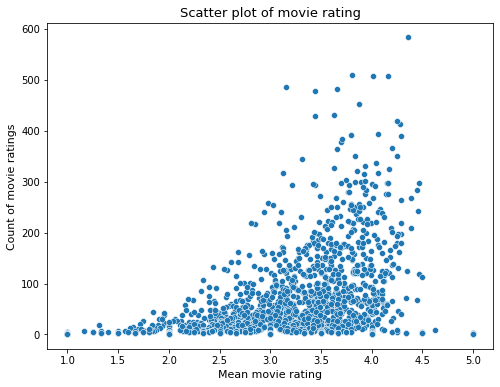

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_grp, x='mean', y='count')
plt.title('Scatter plot of movie rating', fontsize=13)
plt.xlabel('Mean movie rating', fontsize=11)
plt.ylabel('Count of movie ratings', fontsize=11)
plt.show();

In [14]:
genres = list(movies_data.columns[6:])
genre_counts = movies_data[genres].sum(axis=0)
genre_counts= pd.DataFrame(genre_counts,  columns=['counts'])
genre_counts_sorted = genre_counts.sort_values(by = 'counts', ascending=False)

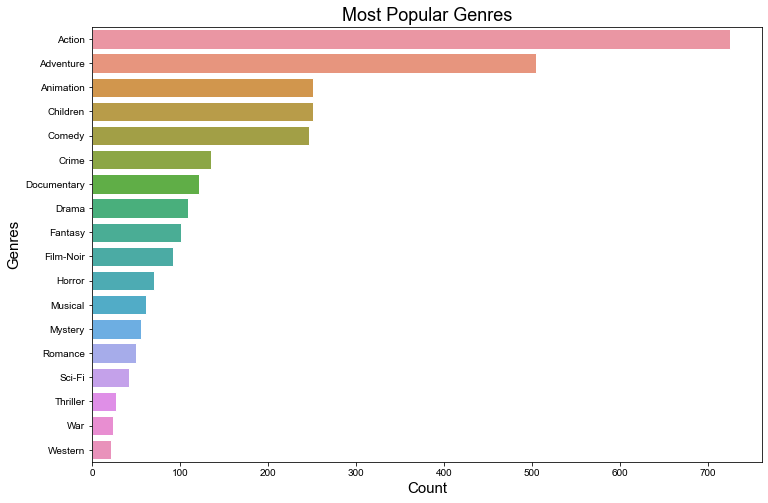

In [15]:
plt.figure(figsize=(12,8))
plt.title('Most Popular Genres', fontsize=18)
plt.ylabel('Genres', fontsize=15)
sns.set(style="darkgrid")
sns.barplot(x='counts',y =genre_counts.index, data=genre_counts_sorted) 
plt.xlabel('Count', fontsize=15);